# Can Online Platforms Benefit from Hosting Collective Action? Estimating the Amount of Reddit Activity Attributable to r/wallstreetbets in Jan 2021
## Nicholas Vincent and Hanlin Li, Northwestern University

First a caveat, and a TLDR!

*Preface/caveat: This is a rough draft work-in-progress notebook, intended as an early
contribution to discussions around r/wallstreetbets GameStop short squeeze and its implications
for social computing. We are open to all sorts of critiques and suggestions
regarding the framing, assumptions, and methods choices. The first author takes
all responsibility for errors in code or claims*.

*Summary/TLDR: using a sample of reddit submissions (sampled using random one minute time windows), we estimate
that r/wallstreetbets was responsible for 1.63-1.72% of all Reddit posts, 0.74-1.21% of all comments, and 0.42-1.17% of total "post scores" in January 2021,
primarily driven by the surge of activity at the end of the month. These estimates suggest
that platforms like reddit may have a
strong incentive to support future instances of "collective action" that are similar to
the "r/wallstreetbets short squeeze".*

The beginning of the [2021 GameStop short squeeze](https://en.wikipedia.org/wiki/GameStop_short_squeeze)
has been attributed to users of the subreddit r/wallstreetbets. For brevity, we'll refer to this (ongoing) event
as the "WSB squeeze".
While it's challenging to prove exactly how much responsibility to assign to the subreddit,
media coverage suggests that (1) the subreddit had a major influence on the WSB short squeeze and
(2) the subreddit recevied massive activity during this period.

Specifically, Morse, writing for Mashable, reported that wallstreetbets was responsible for
 recording breaking [massive traffic](https://mashable.com/article/reddit-wallstreetbets-subreddit-record-traffic-gamestop/) (73M views in 24 hours).
Ghost, writing for Business Insider, summarized evidence from [FrontPage Metrics](https://frontpagemetrics.com/) regarding
r/wallstreetbet's [massive gain in userbase](https://www.businessinsider.com/wallstreetbets-fastest-growing-subreddit-hits-58-million-users-2021-1).
A [post](https://old.reddit.com/r/theoryofwsb/comments/l8uom9/press_roundup_through_30_january_2021/) on r/theoryofwsb highlights the enormous amount of media attention.

Building on the massive interest in the WSB squeeze, in this notebook, we will attempt to use a sample of reddit submissions to estimate the total
number of posts, comments, and upvotes attributable to wallstreetbets in January 2021.

Our intended primary contribution is to provide an easy-to-replicate estimate of total Reddit activity (that does not require
downloading all reddit submissions for a time period). 
This estimate can provide insight into how much online platforms like
reddit stand to benefit from being the "host" of attention grabbing collective efforts like
the WSB squeeze . We note that [reddit itself](https://redditblog.com/2020/12/08/reddits-2020-year-in-review/) uses submissions and comments
as measurements of overall activity, and it seems likely that these activity measurements correlate with ad revenue (though
as we will discuss below, unusual events like the short squeeze may challenge this assumption).

Our secondary contribution is to explore the use of "time window" sampling for reddit. Specfically,
because of the large amount of activity on Reddit, it can be challenging to *quickly* measure something like
the number of total posts on a large, active subreddit such as r/wallstreetbet. While pushshift.io provides
data dumps for past reddit data, very recent data can only be accessed via API. Exactly measuring
the number of posts (or comments, or post score), would require downloading every reddit post, creating
a large time cost in terms of API calls (for both the researcher and the API provider, i.e. pushshift)
and the need to use a large amount of disk space (which may be fine for well resourced researchers, but makes it harder
for interested parties to replicate).

We propose the following sampling approach:

1) divide January 2021 into one minute windows

2) randomly select 1% of these windows

3) collect all reddit posts for each window using the pushshift API. Then get updated post scores via PRAW.

4) treat this 1% sample as a "simple random sample" to produce parameter estimates for the entire month of January

We are very interested in critiques of this approach! The exact sampling code is in `collect-wsb.ipynb`. Before collecting this
data, we experimented with comparing "time window sampled" estimates with full data calculations for individual days.

Returning to the main "research questions" of this notebook, we are motivated by the following broad question:

when a community organizes collective action similar to the r/wallstreetbets short squeeze,
does a platform like reddit benefit from the associated activities? Should platforms like reddit implement design features specifically
to encourage such collective action, and if so what are the potential consequences?

Practically speaking, we focus on three quantitative questions:

1) How many submissions were made to r/wallstreetbets in Jan 2021? 

2) How many comments were made to r/wallstreetbets in Jan 2021?

3) How much "post score" (which we argue is a correlate of pageviews, and thereby ad revenue) is attributable to WSB?

Looking at each of these estimates, we contextualize them using the submissions, comments, and post score from
other subreddits. In other words, we consider r/wallstreetbets activity relative to the rest of reddit.

In [66]:
import pandas as pd
import glob
from datetime import datetime
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint


%precision %.4f
pd.options.display.float_format = '{:,.4f}'.format
# for checking filenames from the notebook
# glob.glob('data/')

We'll use data in `data/start=2021-01-01_00:00:00_end=2021-02-01_00:00:00_n=446_seed=0`

This directory corresponds to 1% sample of 1-minute windows starting at 2021-01-01_00:00:00 and ending at
2021-02-01_00:00:00. In total, we collected all submissions from 446 such 1-minute windows.

In [4]:
submissions = pd.read_csv('data/start=2021-01-01_00:00:00_end=2021-02-01_00:00:00_n=446_seed=0/submissions_with_praw.csv')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (78,81,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,102,105,106,107) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
Loaded 319693 submissions into a dataframe


Below, we create some helpful date and time related columns, then look at descriptive stats
* we look at the subreddits with the most posts in our sample
* we look at descriptive stats for post score and number of comments
* we look at how our posts are distributed over dates

In [89]:
submissions['dt'] = submissions.created_utc.apply(datetime.fromtimestamp)
submissions['date'] = submissions['dt'].apply(datetime.date)
submissions['weekday'] = submissions['dt'].dt.weekday
submissions['day'] = submissions['dt'].dt.day



In [64]:
submissions.subreddit.value_counts()[:20]

wallstreetbets        5350
HotMarthabullles      4511
AskReddit             3586
memes                 2650
u_toronto_news        2265
teenagers             1303
InspirobotBot         1256
dirtykikpals          1083
dogecoin              1028
AutoNewspaper          983
GaySnapchat            973
FreeKarma4U            955
OnlyFansPromotions     835
dankmemes              806
onlyfansgirls101       800
gonewild               773
PokemonGoFriends       769
DiscordNudes           768
DirtySnapchat          727
ksi                    724
Name: subreddit, dtype: int64

In [6]:
submissions[['praw_num_comments', 'praw_score']].describe()

,praw_num_comments,praw_score
count,311091.000000,311091.000000
mean,5.562427,76.768106
std,79.117845,1254.992719
min,0.000000,0.000000
25%,0.000000,1.000000
50%,1.000000,1.000000
75%,3.000000,10.000000
max,38079.000000,133859.000000


In [179]:
#submissions.groupby('date').praw_score.count().sort_index(ascending=False).plot(kind='barh', figsize=(4,6))
posts_by_day = submissions.groupby('day').praw_score.count().sort_index(ascending=False).rename(index='count')
#posts_by_day

<AxesSubplot:xlabel='day', ylabel='count'>

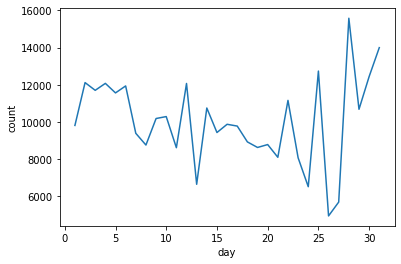

In [92]:
sns.lineplot(data=posts_by_date)

Smell test: Is the number of posts in our sample reasonable relative to the numbers from the [2020 official reddit year in review]
(https://redditblog.com/2020/12/08/reddits-2020-year-in-review/), which suggests in 2020 Reddit recevied
303.4M submissions over 310 days (Jan 1 to Nov 6).

This should give us somewhere around 978k posts per day, or 30.318M posts in a 31-day month.

In [93]:
n_dates = len(set(submissions.date))
print('Posts / days')
print(n / n_dates * 100)
print('Given this is a 1% sample, our estimate for total posts in Jan 2021 is')
print(n * 100 / 1e6, 'M')

Posts / days
1031267.7419354839
Given this is a 1% sample, our estimate for total posts in Jan 2021 is
31.9693 M


Yes, the total number of posts in the sample seems plausible given the figures reported by reddit in 2020.


Below, looking at

1) all posts

2) posts from r/wallstreetbets

we calculate the mean, standard error, and 95% confidence interval for # posts, # comments, and post score.



In [118]:
# create a df with just r/wallstreetbets submissions
wsb = submissions[submissions.subreddit == 'wallstreetbets']
n_wsb = len(wsb)

In [154]:
# some useful reference points:
print('total posts: {}, total score: {}, total comments: {}'.format(
    n,
    submissions.praw_score.sum(),
    submissions.praw_num_comments.sum()
))

total posts: 319693, total score: 23881867.0, total comments: 1730421.0


In [176]:
# average post score and standard error for WSB posts
def stat_helper(name, df, full, cols):
    for col in cols:
        mean = df[col].mean()
        sem = df[col].sem()
        total = full[col].sum()
        print(name, col)
        print('mean is {:.2f} and corresponding standard error is {:.2f}'.format(
            mean, sem
        ))
        ci_lo = mean-1.95*sem
        ci_hi = mean+1.95*sem
        print('95% CI: {:.2f}, {:.2f}'.format(
            ci_lo, ci_hi 
        ))
        print('In terms of percent of the Jan 2021 sum, mean: {:.2f} sem: {:.2f}, ci: {:.2f}, {:.2f}'.format(
            mean*len(df)/total*100, sem*len(df)/total*100, ci_lo*len(df)/total * 100, ci_hi*len(df)/total*100
        ))
        print()
stat_helper('All Submissions', submissions, submissions, ['praw_score', 'praw_num_comments'])
stat_helper('r/wallstreetbets Submissions', wsb, submissions, ['praw_score', 'praw_num_comments'])


All Submissions praw_score
mean is 76.77 and corresponding standard error is 2.25
95% CI: 72.38, 81.16
In terms of percent of the Jan 2021 sum, mean: 102.77 sem: 3.01, ci: 96.89, 108.64

All Submissions praw_num_comments
mean is 5.56 and corresponding standard error is 0.14
95% CI: 5.29, 5.84
In terms of percent of the Jan 2021 sum, mean: 102.77 sem: 2.62, ci: 97.65, 107.88

r/wallstreetbets Submissions praw_score
mean is 35.45 and corresponding standard error is 8.52
95% CI: 18.84, 52.06
In terms of percent of the Jan 2021 sum, mean: 0.79 sem: 0.19, ci: 0.42, 1.17

r/wallstreetbets Submissions praw_num_comments
mean is 3.15 and corresponding standard error is 0.39
95% CI: 2.38, 3.91
In terms of percent of the Jan 2021 sum, mean: 0.97 sem: 0.12, ci: 0.74, 1.21



In [196]:
print('r/wallstreets has {:.2f} submissions in our sample and makes up {:.2f} percent of the sample'.format(
    n_wsb, n_wsb / len(submissions)*100
))
print('Because this is a 1% sample, we estimate that r/wallstreetbets had 535,000 of 31,969,300 total submissions.')
ci_low, ci_upp = proportion_confint(n_wsb, n, alpha=0.05, method='normal')
print('95% CI for proportion: {:.2f}, {:.2f}'.format(ci_low*100, ci_upp*100))

r/wallstreets has 5350.00 submissions in our sample and makes up 1.67 percent of the sample
Because this is a 1% sample, we estimate that r/wallstreetbets had 535,000 of 31,969,300 total submissions.
95% CI for proportion: 1.63, 1.72


What are the subreddits with the most submissions, post score, and number of comments?

Let's look at the top ten for each.

First, top subreddits by summed post score from our sample. Below values show
each subreddit's percent of total Jan 2021 post score.

In [197]:
submissions.groupby('subreddit').praw_score.sum().sort_values(ascending=False)[:10] * 100 / submissions.praw_score.sum()

subreddit
memes               10.0780
politics             2.1209
nextfuckinglevel     1.8017
dankmemes            1.6541
aww                  1.6418
interestingasfuck    1.3689
MadeMeSmile          0.8750
funny                0.8466
Minecraft            0.8376
wallstreetbets       0.7942
Name: praw_score, dtype: float64

Next, top subreddit by total number of comments in our sample. Similarly, the values below show
each subreddit's percent of (estimated) total Jan 2021 comments. 

In [198]:
submissions.groupby('subreddit').praw_num_comments.sum().sort_values(ascending=False)[:10] * 100 / submissions.praw_num_comments.sum()

subreddit
neoliberal       2.2527
AskReddit        2.0334
memes            1.4345
politics         1.3327
wallstreetbets   0.9729
teenagers        0.8514
worldnews        0.7274
nba              0.6819
AmItheAsshole    0.6431
RedditSessions   0.6070
Name: praw_num_comments, dtype: float64

Finally, top subreddits by total number of posts in our sample (again, as percent of Jan 2021).

In [199]:
submissions.groupby('subreddit').praw_num_comments.count().sort_values(ascending=False)[:10].rename(index='count') * 100 / submissions.praw_num_comments.count()

subreddit
wallstreetbets     1.7198
HotMarthabullles   1.4501
AskReddit          1.1527
memes              0.8518
u_toronto_news     0.7281
teenagers          0.4188
InspirobotBot      0.4037
dirtykikpals       0.3481
dogecoin           0.3304
AutoNewspaper      0.3160
Name: count, dtype: float64

Putting it all together, showing total post *counts* alongside score and comment *percents*.

In [165]:
counts = submissions.groupby('subreddit').praw_score.count() * 100
counts.rename(index='count', inplace=True)
scores = submissions.groupby('subreddit').praw_score.sum() / submissions.praw_score.sum() * 100
comments = submissions.groupby('subreddit').praw_num_comments.sum() / submissions.praw_num_comments.sum() * 100
merged = pd.concat([counts, scores, comments], axis=1)
# = submissions[['subreddit', 'praw_score', 'praw_num_comments']].groupby('subreddit').sum()
merged.sort_values('praw_score', ascending=False)[:20]

,count,praw_score,praw_num_comments
subreddit,,,
memes,265000,10.0780,1.4345
politics,50600,2.1209,1.3327
nextfuckinglevel,9900,1.8017,0.4651
dankmemes,80600,1.6541,0.3215
aww,68800,1.6418,0.2839
interestingasfuck,12600,1.3689,0.3572
MadeMeSmile,8300,0.8750,0.1373
funny,47200,0.8466,0.3970
Minecraft,55800,0.8376,0.3317


So far, these results seem to suggest that the huge amount of "collective action" related posts, comments,
and votes helped put r/wallstreetbets up there with other highly active subreddits, but
r/wallstreetbets did not necessarily blow every other subreddit 
out of the water.

One puzzle is how these estimates relate to the claims from the above Mashable article about record
breaking pageviews. It could be that for this unusual, attention-grabbing action,
post score is not a good correlate for pageviews.

In other words, r/wallstreetbets may have received an unusually large amount of 
viewership without visible engagement.

On the other hand, the surge in new users should be visible in this data.

A simple way to unpack this data could be to ask: what would reddit activity totals have looked like without 
r/wallstreetbets?

In [181]:
total_posts_without_wsb = submissions.praw_score.count() - wsb.praw_score.count()
wsb.praw_score.count() / total_posts_without_wsb * 100

1.7498470928007694

In [169]:
total_score_without_wsb = submissions.praw_score.sum() - wsb.praw_score.sum()
wsb.praw_score.sum() / total_score_without_wsb * 100

0.8005206437931529

Now for some napkin math / speculation.
Let's assume for January 2021, reddit expected \$9.91M in revenue
(conservatively drawing on [emarketer.com's \$119M per year estimate from 2019](https://www.emarketer.com/content/reddit-to-cross-100-million-in-ad-revenues-in-2019)).

If we make the (large) simplifying assumption that ad revenue scales with total post score 
(because post score correlates with page views, an assumption for which there is [some evidence](https://ojs.aaai.org/index.php/ICWSM/article/view/14700))
, the 0.8% increase in post score 
would correspond to an increase in revenue of \$78k (see below cell). If we were to use comment count instead
of post score, this figure would be \$96k. Of course, these figures do not account for ongoing activity (i.e. whatever happens in February)
or the long term effects of gaining completely new users.

If we were to instead use post count instead of post score, this figure would be \$170k. However, this
estimate is almost certainly the least accurate, because low score posts, including spam, do not contribute to revenue.

While assumption-reliant, these are nonetheless useful ballpark figures for thinking about the
incentives for platforms to scafflod and "encourage" collective action similar to this event.


In [184]:
9.91e6 / submissions.praw_score.sum() * wsb.praw_score.sum()

78701.57345738506

In [185]:
9.91e6 / submissions.praw_score.count() * wsb.praw_score.count()

170427.62407141319

In [187]:
9.91e6 / submissions.praw_num_comments.sum() * wsb.praw_num_comments.sum()

96412.86715776104

# Some additional interesting plots
* WSB metrics over time (recall that because this is a 1% sample, these are in units of 100s)
* ...more to come?

Text(0.5, 1.0, 'Total Posts')

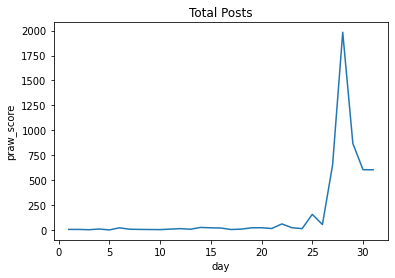

In [162]:
ax = sns.lineplot(data=wsb.groupby('day').praw_score.count())
ax.set_title('WSB # Posts')

Text(0.5, 1.0, 'Total Score')

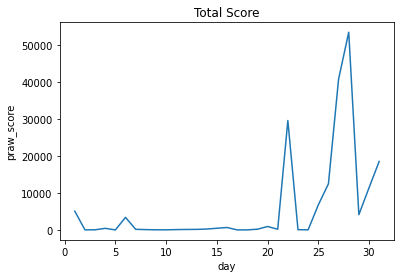

In [163]:
ax = sns.lineplot(data=wsb.groupby('day').praw_score.sum())
ax.set_title('WSB Summed Scores')

Text(0.5, 1.0, 'WSB # Comments')

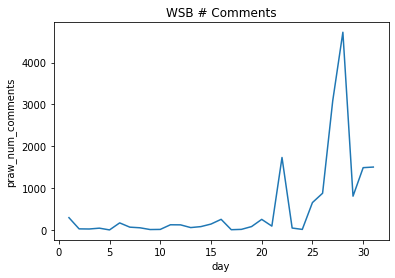

In [164]:
ax = sns.lineplot(data=wsb.groupby('day').praw_num_comments.sum())
ax.set_title('WSB # Comments')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9d8dd8e7-abf2-4721-84cd-03779d208ef5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>